### 3.2.1 トレンドの推定 

In [1]:
!pip install pykalman

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pykalman import KalmanFilter 

In [3]:
import requests
import io

# 月ごとの飛行機の乗客数データ
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
df_content = pd.read_csv(io.StringIO(stream.decode('utf-8')))
df_content['Month'] = pd.to_datetime(df_content['Month'], infer_datetime_format=True)
y = pd.Series(df_content["#Passengers"].values, index=df_content['Month'])
y = y.astype('f')

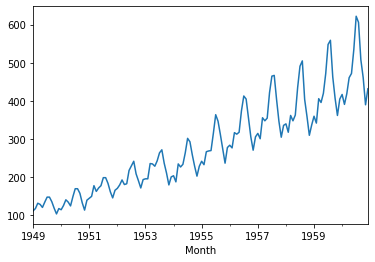

In [4]:
y.plot();

In [5]:
# 推移行列などの初期化
def FGHset(n_dim_trend, n_dim_obs=1, n_dim_series=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend!=0) + (n_dim_series!=0)
    if n_dim_series>0:
        n_dim_state = n_dim_trend + n_dim_series - 1
    else:
        n_dim_state = n_dim_trend
    
    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
  
    # 各行列のトレンド成分に対するブロック行列を構築
    G[0,0] = 1
    H[0,0] = 1
    
    # トレンドモデルの推移行列の構築
    # 非定常過程でも対応できる推移行列を構築 
    if n_dim_trend==1: 
        F[0,0] = 1
    elif n_dim_trend==2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend==3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1
        
    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)
    
    return n_dim_state, F, H, Q

In [6]:
# 観測値の次元数
n_dim_obs = 1
# トレンドの次元数
n_dim_trend = 2

# 推移行列などの定義
n_dim_state, F, H, Q = FGHset(n_dim_trend, n_dim_obs)

In [7]:
# 状態の平均値ベクトルの初期値
initial_state_mean = np.zeros(n_dim_state)
# 状態の分散共分散行列の初期値
initial_state_covariance = np.ones((n_dim_state, n_dim_state))

# カルマンフィルタのモデル生成
kf = KalmanFilter(
    # l：観測値の次元数
    n_dim_obs=n_dim_obs,
    # k：状態の次元数
    n_dim_state=n_dim_state,
    # x_0：状態の平均値ベクトルの初期値（k次元）
    initial_state_mean=initial_state_mean,
    # V_0：状態の分散共分散行列の初期値（k×k次元）
    initial_state_covariance=initial_state_covariance,
    # F：推移行列（k×k次元）
    transition_matrices=F,
    # H：観測行列（l×k次元）
    observation_matrices=H,
    # R：観測ノイズwの分散共分散行列（l×l次元。観測値が一次元の場合はスカラ）
    observation_covariance=1.0,
    # Q：システムノイズvの分散共分散行列（m×m次元）
    transition_covariance=Q)

In [8]:
# 前半120時点を学習データに121時点以降のデータを検証用に使用
n_train = 120
train, test = y.values[:n_train], y.values[n_train:]
n_test = len(y.values[n_train:])

In [9]:
# 一期先予測＋フィルタ（返り値はフィルタ）
filtered_state_means, filtered_state_covs = kf.filter(train)

In [10]:
# フィルタ＋平滑化(返り値は平滑化)
smoothed_state_means, smoothed_state_covs = kf.smooth(train)
# 平滑化に対する観測値の予測を計算
pred_o_smoothed = smoothed_state_means.dot(H.T)

In [11]:
# フィルタの結果（平均）のサイズ：n_train * n_dim_state 
smoothed_state_means.shape

(120, 2)

In [12]:
# フィルタの結果（共分散行列）のサイズ：n_train * n_dim_state * n_dim_state
smoothed_state_covs.shape

(120, 2, 2)

In [13]:
pred_o_smoothed = smoothed_state_means.dot(H.T)

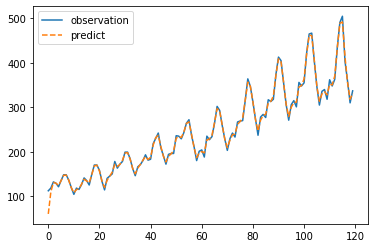

In [14]:
plt.plot(train, label="observation")
plt.plot(pred_o_smoothed, '--', label="predict")
plt.legend();

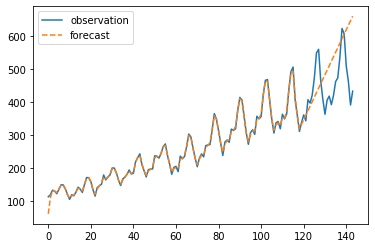

In [15]:
plt.plot(y.values, label="observation")

# 長期予測格納用のベクトルを用意（値は全て入れ替わるため0で初期化しなくてよい）
pred_y = np.empty(len(test))

# 現在の状態と分散共分散行列を取得
current_state = smoothed_state_means[-1]
current_cov = smoothed_state_covs[-1]
for i in range(len(test)):
    # filter_updateは観測値を入力しなければ1期先予測のみを実行する
    current_state, current_cov = kf.filter_update(current_state, 
                                                  current_cov, 
                                                  observation=None)
    pred_y[i] = kf.observation_matrices.dot(current_state)

# np.hstackはnp.concatenateでもよい
plt.plot(np.hstack([pred_o_smoothed.flatten(), pred_y]), '--', label="forecast")
plt.legend();

#### 3.2.1のモデル（トレンドを推定したモデル）の残差分析

カルマンフィルタ（野村，p95）に倣って、トレンド成分モデルだけでは不十分なことを確認するために、一期先予測誤差（観測値と、推定された状態から観測方程式で求まる予測との差）のコレログラムを確認する。

In [16]:
pred_o_smoothed.flatten().shape

(120,)

In [17]:
pred_y.shape

(24,)

In [18]:
np.concatenate([pred_o_smoothed.flatten(), pred_y]).shape

(144,)

In [19]:
# 一期先予測誤差の計算
one_term_pred = np.empty(n_train + n_test)

## 長期予測のコード（島田,p120）と似ているが、こちらでは各フィルタを更新している点で異なる
filtered_means, filtered_covs = kf.filter(y)

for i in range(len(one_term_pred)):
    current_mean, current_cov = kf.filter_update(filtered_means[i], filtered_covs[i], observation=None)
    one_term_pred[i] = kf.observation_matrices.dot(current_mean)

one_term_pred_err = y - one_term_pred

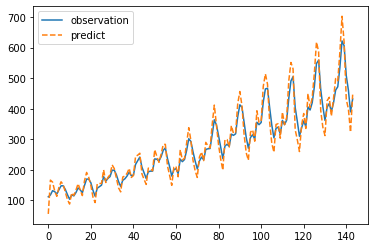

In [20]:
# 観測値と、一期先予測に対する観測値の予測の比較
plt.plot(y.values, label="observation")
plt.plot(one_term_pred, '--', label="predict")
plt.legend();

In [21]:
# 散漫な初期時点のチェック
one_term_pred_err.head(10)

Month
1949-01-01    56.000000
1949-02-01   -48.521739
1949-03-01   -28.122093
1949-04-01    -2.489018
1949-05-01     7.457989
1949-06-01    -7.934465
1949-07-01   -13.164222
1949-08-01    -3.629769
1949-09-01     8.969350
1949-10-01    16.034074
dtype: float64

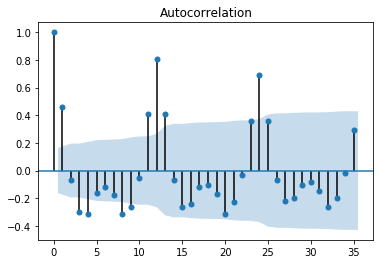

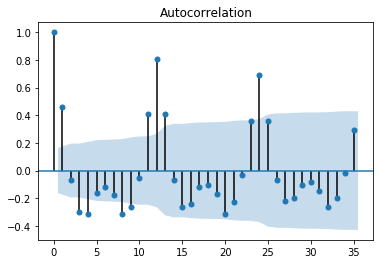

In [22]:
import statsmodels.api as sm

# 一期先予測誤差の、ラグに対する標本自己相関関数の値（散漫な初期時点は除く；除かなければ結果は大きく変わってくる）
sm.graphics.tsa.plot_acf(one_term_pred_err, lags=35)

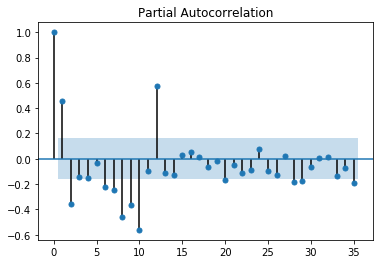

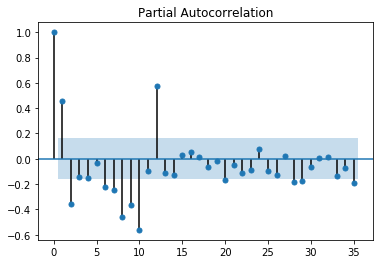

In [23]:
# 標本偏自己相関関数（PACF: partial autocorrelation）（散漫な初期時点は除く）
sm.graphics.tsa.plot_pacf(one_term_pred_err, lags=35)

PACFのグラフを見ると、ラグ12では大きな自己相関が見られる（ラグ10やラグ8もだが）。ここから、季節成分に関わる残差に自己相関が残っていることが分かる。

In [24]:
F

array([[ 2., -1.],
       [ 1.,  0.]])

### 3.2.2 季節調整モデル 

In [25]:
# 推移行列などの初期化（後半の部分がトレンドのみ考慮した場合と異なる）
def FGHset(n_dim_trend, n_dim_obs=1, n_dim_series=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend!=0) + (n_dim_series!=0)
    if n_dim_series>0:
        n_dim_state = n_dim_trend + n_dim_series - 1
    else:
        n_dim_state = n_dim_trend
    
    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
    
    ## トレンドモデルのブロック行列の構築
    G[0,0] = 1
    H[0,0] = 1
    if n_dim_trend==1: 
        F[0,0] = 1
    elif n_dim_trend==2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend==3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1
        
    start_elem = n_dim_trend
    start_col = n_dim_trend
    # 季節調整成分のブロック行列の構築
    if n_dim_series>0:
        G[start_elem, 1] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_series-1): 
            F[start_elem, start_elem+i] = -1
        for i in range(n_dim_series-2): 
            F[start_elem+i+1, start_elem+i] = 1
    
    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)
    
    return n_dim_state, F, H, Q

In [26]:
# 観測値の次元数
n_dim_obs = 1
# トレンドの次元数
n_dim_trend = 2
# 季節成分の次元数
n_dim_series = 12

# 推移行列などの定義
n_dim_state, F, H, Q = FGHset(n_dim_trend, n_dim_obs, n_dim_series)

In [27]:
# 状態の平均値ベクトルの初期値
initial_state_mean = np.zeros(n_dim_state)
# 状態の分散共分散行列の初期値
initial_state_covariance = np.ones((n_dim_state, n_dim_state))

# カルマンフィルタのモデル生成
kf = KalmanFilter(
    # l：観測値の次元数
    n_dim_obs=n_dim_obs,
    # k：状態の次元数
    n_dim_state=n_dim_state,
    # x_0：状態の平均値ベクトルの初期値（k次元）
    initial_state_mean=initial_state_mean,
    # V_0：状態の分散共分散行列の初期値（k×k次元）
    initial_state_covariance=initial_state_covariance,
    # F：推移行列（k×k次元）
    transition_matrices=F,
    # H：観測行列（l×k次元）
    observation_matrices=H,
    # R：観測ノイズwの分散共分散行列（l×l次元。観測値が一次元の場合はスカラ）
    observation_covariance=1.0,
    # Q：システムノイズvの分散共分散行列（m×m次元）
    transition_covariance=Q)

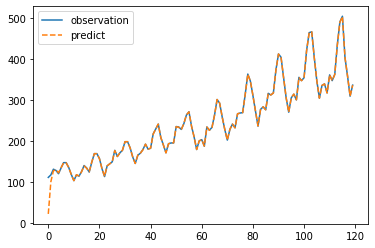

In [28]:
# フィルタ＋平滑化
smoothed_state_means, smoothed_state_covs = kf.smooth(train)
pred_o_smoothed = smoothed_state_means.dot(H.T)
plt.plot(train, label='observation')
plt.plot(pred_o_smoothed, '--', label='predict')
plt.legend();

#### 3.2.2のモデル（トレンド＋季節成分のモデル）の残差分析

カルマンフィルタ（野村，p95）に倣って、トレンド成分モデルと季節成分モデルだけでは不十分なことを確認するために、一期先予測誤差（観測値と、推定された状態から観測方程式で求まる予測との差）のコレログラムを確認する。

In [29]:
# 一期先予測誤差の計算
one_term_pred = np.empty(n_train + n_test)

## 長期予測のコード（島田,p120）と似ているが、こちらでは各フィルタを更新している点で異なる
filtered_means, filtered_covs = kf.filter(y)

for i in range(len(one_term_pred)):
    current_mean, current_cov = kf.filter_update(filtered_means[i], filtered_covs[i], observation=None)
    one_term_pred[i] = kf.observation_matrices.dot(current_mean)

one_term_pred_err = y - one_term_pred

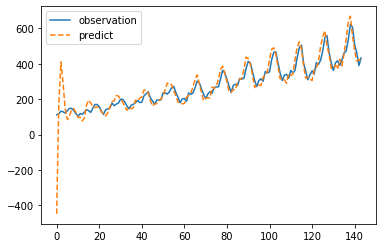

In [30]:
# 観測値と、一期先予測に対する観測値の予測の比較
plt.plot(y.values, label="observation")
plt.plot(one_term_pred, '--', label="predict")
plt.legend();

In [31]:
# 散漫な初期時点がありそうである（4時点まで？）
one_term_pred_err.head(10)

Month
1949-01-01    560.000000
1949-02-01    -54.429268
1949-03-01   -278.336062
1949-04-01   -163.221507
1949-05-01    -24.606132
1949-06-01     50.322367
1949-07-01     43.202042
1949-08-01      8.943664
1949-09-01    -10.444526
1949-10-01     -7.028826
dtype: float64

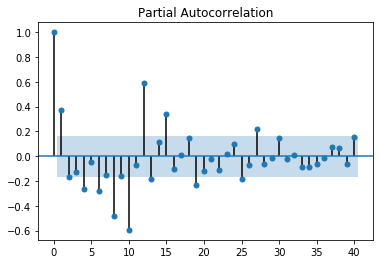

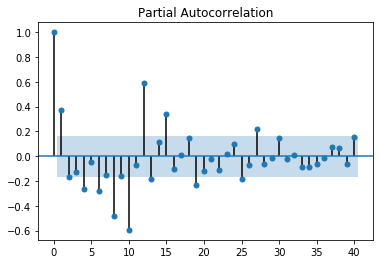

In [32]:
# 標本偏自己相関関数（PACF: partial autocorrelation）（散漫な初期時点は除く）
sm.graphics.tsa.plot_pacf(one_term_pred_err[4:], lags=40)

トレンドのみを考慮したモデルと比べ、改善したかどうか微妙である。

In [33]:
F

array([[ 2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]])

#### EMアルゴリズムによるハイパーパラメータ（観測・状態方程式の行列や撹乱項の共分散行列）最適化

長期予測の結果を見て、初期時点でのハイパーパラメータがまずかったことを確認する。その後EMアルゴリズムを用いて最適化し、再び残差分析を行う。

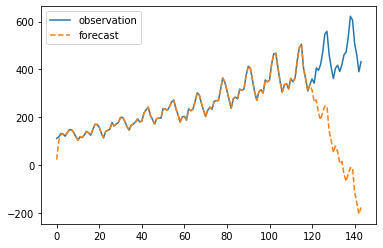

In [34]:
# 長期予測
plt.plot(y.values, label='observation')

pred_y = np.empty(len(test))
current_state = smoothed_state_means[-1]
current_cov = smoothed_state_covs[-1]
for i in range(len(test)):
    current_state, current_cov = kf.filter_update(current_state, current_cov, observation=None)
    pred_y[i] = kf.observation_matrices.dot(current_state)
plt.plot(np.hstack([pred_o_smoothed.flatten(), pred_y]), '--', label='forecast')
plt.legend();

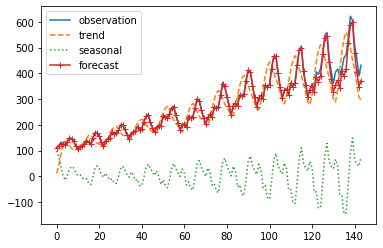

In [35]:
# EMアルゴリズムによるF, H, Q, Rの最適化（繰り返し回数は10回）
emed_kf = kf.em(train, n_iter=10, em_vars='all')

em_smoothed_state_means, em_smoothed_state_covs = emed_kf.smooth(train)

# 階差
diff = 2

# トレンド成分
t_em_pred_o_smoothed = np.dot(em_smoothed_state_means[:, :diff], emed_kf.observation_matrices[:, :diff].T)

# 季節成分
# 季節成分は状態ベクトルにおいてトレンド成分以降の要素が対象
s_em_pred_o_smoothed = np.dot(em_smoothed_state_means[:, diff:], emed_kf.observation_matrices[:, diff:].T)

# EMアルゴリズムによる最適化後の長期予測
current_state = em_smoothed_state_means[-1]
current_cov = em_smoothed_state_covs[-1]

# トレンド成分と季節成分の長期予測値を格納するベクトルを用意
t_pred_y = np.empty(len(test))
s_pred_y = np.empty(len(test))

# トレンド成分および季節成分の長期予測
for i in range(len(test)):
    current_state, current_cov = emed_kf.filter_update(current_state, current_cov, observation=None)
    t_pred_y[i] = emed_kf.observation_matrices[:, :diff].dot(current_state[:diff])
    s_pred_y[i] = emed_kf.observation_matrices[:, diff:].dot(current_state[diff:])
plt.plot(y.values, label='observation')
plt.plot(np.hstack([t_em_pred_o_smoothed.flatten(), t_pred_y]), '--', label='trend')
plt.plot(np.hstack([s_em_pred_o_smoothed.flatten(), s_pred_y]), ':', label='seasonal')
plt.plot(np.hstack([s_em_pred_o_smoothed.flatten()+t_em_pred_o_smoothed.flatten(), s_pred_y+t_pred_y]), '+-', label="forecast")
plt.legend();

In [36]:
# EM後の残差分析
## 一期先予測誤差の計算
one_term_pred = np.empty(n_train + n_test)
em_filtered_means, em_filtered_covs = emed_kf.filter(y)

for i in range(len(one_term_pred)):
    current_mean, current_cov = emed_kf.filter_update(em_filtered_means[i], em_filtered_covs[i], observation=None)
    one_term_pred[i] = emed_kf.observation_matrices.dot(current_mean)

one_term_pred_err = y.values - one_term_pred

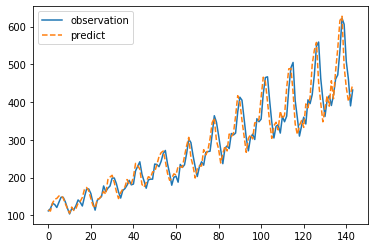

In [37]:
## 観測値と、一期先予測に対する観測値の予測の比較
plt.plot(y.values, label="observation")
plt.plot(one_term_pred, '--', label="predict")
plt.legend();

In [38]:
y.values - one_term_pred

array([ -2.74956302,   6.52253932,  -0.78103287, -14.15122414,
       -23.97620812, -16.56548722,  -4.29166319,   2.11760968,
         4.79014324,   1.15949692,  -2.11804031,  -4.05569692,
         1.91570478,   7.51030545,   8.71260636,  -2.10094529,
       -22.73158063, -20.00461883,  -4.01732057,   4.66460493,
        13.66792612,   7.24195057,  -6.12675035,  -2.99621835,
         0.42622184,  -2.62119665,  14.46795871,   6.7747493 ,
       -22.78797141, -23.69962616,  -7.29995568,  11.68310435,
        20.94057083,  17.28953462, -14.3677378 ,  -3.5362963 ,
        -4.32614788, -14.9599533 ,  11.082459  ,  -2.33835477,
       -18.9778335 , -19.74640197,  -1.41328487,  19.18838039,
        26.84441062,  16.30575106, -15.09250841,  -8.52479079,
        -3.60588051, -19.33396248,  20.3972165 ,   1.01037058,
       -26.1962527 , -23.02047925,  -6.5559661 ,  28.33435643,
        25.34909526,  18.13301742, -18.65310851,  -9.03762151,
        -3.10159163, -42.40503626,   6.60999986,  -0.64

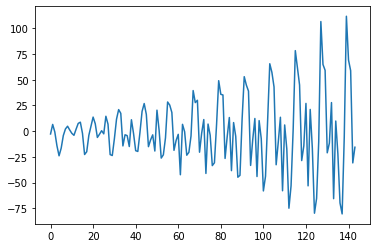

In [39]:
plt.plot(one_term_pred_err)

C:\Users\juvet\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


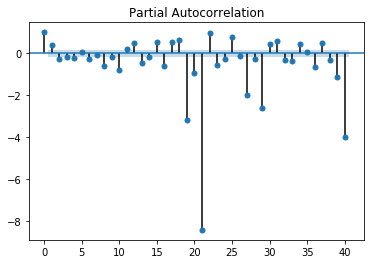

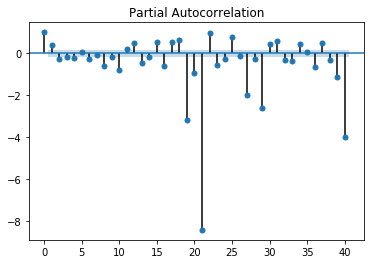

In [40]:
# 標本偏自己相関関数（PACF: partial autocorrelation）（散漫な初期時点は無さそう）
sm.graphics.tsa.plot_pacf(one_term_pred_err, lags=40)

トレンド成分＋季節調整モデルにEMアルゴリズムを使った最適化でも改善されていない（むしろ悪化した）。

### 3.2.3 AR成分付き季節調整モデル

In [78]:
# 推移行列などの初期化
def FGHset(n_dim_trend, 
           n_dim_obs=1, n_dim_series=0, n_dim_ar=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend!=0) + (n_dim_series!=0) + (n_dim_ar!=0)
    if n_dim_series>0 or n_dim_ar>0:
        n_dim_state = n_dim_trend + n_dim_series + n_dim_ar - 1
    else:
        n_dim_state = n_dim_trend
    
    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
    
    ## トレンドモデルのブロック行列の構築
    G[0,0] = 1
    H[0,0] = 1
    if n_dim_trend==1: 
        F[0,0] = 1
    elif n_dim_trend==2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend==3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1
        
    start_elem = n_dim_trend
    start_col = n_dim_trend
    # 季節調整成分のブロック行列の構築
    if n_dim_series>0:
        G[start_elem, 1] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_series-1): 
            F[start_elem, start_elem+i] = -1
        for i in range(n_dim_series-2): 
            F[start_elem+i+1, start_elem+i] = 1

        start_elem = n_dim_trend + n_dim_series - 1
        start_col = n_dim_trend + n_dim_series - 1
            
    # AR成分のブロック行列の構築
    if n_dim_ar>0:
        G[start_elem, 2] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_ar): 
            F[start_elem, start_elem+i] = 0
        for i in range(n_dim_ar-1): 
            F[start_elem+i+1, start_elem+i] = 1

            
    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)
    
    return n_dim_state, F, H, Q

In [79]:
# 観測値の次元数
n_dim_obs = 1
# トレンドの次元数
n_dim_trend = 2
# 季節成分の次元数
n_dim_series = 12
# AR成分の次元数
n_dim_ar = 2

# 推移行列などの定義
n_dim_state, F, H, Q = FGHset(n_dim_trend, n_dim_obs, n_dim_series, n_dim_ar)

# 状態の平均値ベクトルの初期値
initial_state_mean = np.zeros(n_dim_state)
# 状態の分散共分散行列の初期値
initial_state_covariance = np.ones((n_dim_state, n_dim_state))

# カルマンフィルタのモデル生成
kf = KalmanFilter(
    # l：観測値の次元数
    n_dim_obs=n_dim_obs,
    # k：状態の次元数
    n_dim_state=n_dim_state,
    # x_0：状態の平均値ベクトルの初期値（k次元）
    initial_state_mean=initial_state_mean,
    # V_0：状態の分散共分散行列の初期値（k×k次元）
    initial_state_covariance=initial_state_covariance,
    # F：推移行列（k×k次元）
    transition_matrices=F,
    # H：観測行列（l×k次元）
    observation_matrices=H,
    # R：観測ノイズwの分散共分散行列（l×l次元。観測値が一次元の場合はスカラ）
    observation_covariance=1.0,
    # Q：システムノイズvの分散共分散行列（m×m次元）
    transition_covariance=Q)

In [80]:
from scipy.optimize import minimize
import copy


# parcorを用いたAR係数の推定
def ar_coef(parcor, n_dim_ar):
    ar_hat = np.zeros(n_dim_ar)
    am = np.zeros(n_dim_ar)
    if n_dim_ar==1:
        ar_hat = parcor
    else:
        for i in range(n_dim_ar):
            ar_hat[i] = parcor[i]
            am[i] = parcor[i]
            if i > 0:
                for j in range(i):
                    # m次のj番目の係数の算出
                    # am[j]はm-1次のj番目の係数
                    # am[i-j]はm-j次のm-j番目の係数
                    ar_hat[j] = am[j] - parcor[i] * am[i-j]
#                 if i < n_dim_ar-1:
#                     for j in range(i-1):
#                         am[j] = ar_hat[j]
    return ar_hat


# AR係数最適化のための対数尤度の計算
def ar_n_minimize_likelihood(target, kf, train, 
                             idx_target_parcor, st_row, st_col):
    kf.transition_matrices[st_row, st_col+idx_target_parcor] = target
    kf.smooth(train)

    # "masked arrays are not supported"というエラーが発生した場合は
    # https://github.com/pykalman/pykalman/issues/83
    # などを参照してPykalmanのコードを修正してほしい
    return -kf.loglikelihood(train)


# システムノイズの分散共分散行列最適化のための対数尤度の計算
def Q_minimize_likelihood(targets, kf, train, target_idx):
    for i, (r,c) in enumerate(target_idx):
        kf.transition_covariance[r, c] = targets[i]
    kf.smooth(train)
    return -kf.loglikelihood(train)

In [81]:
n_q = 2
# トレンド成分、季節成分、AR成分の分散の最適化の範囲
q_bnds = ((1e-4, 1e3),) * (n_q) + ((1e-4, 5e1),)
# AR成分の最適化の範囲
ar_bnds = ((-0.95, 0.95), )
# 行列GのAR成分成分の位置
st_row = n_dim_trend + n_dim_series - 1
st_col = n_dim_trend + n_dim_series - 1
# 最適化の繰り返し回数
n_iter = 2

# ハイパーパラメタ調整前のモデルを残すために
# オブジェクトをコピーしておく
q_kf = copy.deepcopy(kf)

# AR成分を個別に最適化
for idx_target_parcor in range(n_dim_ar):
    ar_idx_end = st_col + idx_target_parcor
    for i_opt in range(n_iter):
        if idx_target_parcor > 0:
            ar_args = q_kf.transition_matrices[st_row, 
                                               st_col:ar_idx_end]
            ar_cov = [q_kf.transition_covariance[st_row+i, st_col+i] 
                      for i in range(idx_target_parcor)]

        if i_opt==0:
            q_kf = copy.deepcopy(kf)
            
        if idx_target_parcor > 0:
            q_kf.transition_matrices[st_row, st_col:ar_idx_end] = ar_args
            for i in range(idx_target_parcor):
                q_kf.transition_covariance[st_row+i, st_col+i] = ar_cov[i]

        args = (q_kf, train, idx_target_parcor, st_row, st_col)
        # 対象のparcorの係数の最適化
        minimize(ar_n_minimize_likelihood, 
                 (0.,), 
                 args=args, 
                 method='SLSQP', 
                 bounds=ar_bnds)

        q_args = (q_kf, train, [(st_row, st_col)])
        # AR成分の分散共分散行列の要素の最適化
        minimize(Q_minimize_likelihood, 
                 (0., ), 
                 args=q_args, 
                 method='SLSQP', 
                 bounds=(q_bnds[2],))

        q_args = (q_kf, train, [(n_dim_trend, n_dim_trend)])
        # 季節成分の分散共分散行列の要素の最適化
        minimize(Q_minimize_likelihood,
                 (0.,),
                 args=q_args,
                 method='SLSQP',
                 bounds=(q_bnds[1],))

        q_args = (q_kf, train, [(0, 0)])
        # トレンド成分の分散共分散行列の要素の最適化
        minimize(Q_minimize_likelihood,
                 (0.,),
                 args=q_args,
                 method='SLSQP',
                 bounds=(q_bnds[0],))
        
        if idx_target_parcor==0:
            q_kf.transition_matrices[st_row, st_col] = \
                ar_coef(q_kf.transition_matrices[st_row, st_col], 1)
        else:
            q_kf.transition_matrices[st_row, st_col:ar_idx_end+1] = \
                ar_coef(q_kf.transition_matrices[st_row,
                                                 st_col:ar_idx_end+1],
                        idx_target_parcor+1)

In [82]:
n_dim_ar = 3
parcor = [1, 2, 3]

In [83]:
ar_coef(parcor, n_dim_ar)

array([-8., -4.,  3.])

In [84]:
8.50 * 30 / 4 * 27.19 + 992.31

2725.6725